In [13]:
%%html
<style>
    .yellow {
        background-color: #eddd6e;
    }
</style>


### A Recommendation engine for recommending product bundles

In this notebook, I develop a recommendation engine for an online shop and evaluate the results. I want to recommend products to the customers that might be interesting to buy in bundles.
The original dataset is taken from [Kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data). 

The data has been cleaned in the [EDA_and_cleaning.ipynb](EDA_and_cleaning.ipynb) notebook, which you can find in the same directory as this notebook.



<a id='TOC'/>

## Table of Content (TOC)
1. [Introduction (the plan):](#intro)
2. [Imports](#imports)
3. [Product Segmentation](#product_segmentation)
4. [Recommendations for one customer based on his purchases](#test_rec)
5. [Train/Test Split](#split)
6. [Method 1: Recommending one product each from several top categories](#m1)
7. [Method 2: Recommending several products from the top 1 category](#m2)
8. [Method 3: (For business impact evaluation) recommending products **randomly**](#m3)
9. [Conclusion](#conclusion)


<a id='intro'/>

## Introduction (the plan):
[back to TOC](#TOC)

The dataset contains two main types of information that can be leveraged for a recommendation system.
1. Product `Description`s: Each product is described in words. 
2. `CustomerID` information: Each purchase is associated with the respective customer
3. Information about items, their quantity and price that were bought together

Number 1 enables us to segment products into classes of products.\
Number 2 allows us then to (a) identify customers with similar interests, and (b) associate products and classes of products with those customers.

By combining 1 and 2, one can, for each customer A
- identify another customer B that has the most similar interests to customer A
- identify the product classes associated with customer A's purchased items
- recommend products from these classes to customer B 

For the product segmentation, I create word embeddings from the `Describtion` column and apply an Agglomerative Clustering algorithm to group the products into classes.\
The customer similarity is quantified using the concept of cosine similarity to find each customer's "next neighbor".

For the final recommendation, I test two methods:
1. I identify the TOP 5 product-classes (i.e. the product classes from which the most purchases were made) of the "next neighbor" and recommend one product from each category.
2. I identify the single TOP product-class of the "next neighbor" and recommend 5 products from this class.

The methods are also tested against a "dummy" model, whis is: 5 products are drawn from a random product-class.




<a id='imports'/>

## Imports

[back to TOC](#TOC)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim.downloader

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import  silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /home/karol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df0 = pd.read_pickle("data/data_cleaned.pkl")  

<a id='#product_segmentation'/>

## Product Segmentation

[back to TOC](#TOC)

In [3]:
unique_descriptions=df0['Description'].unique()

<div class="yellow">
Here, a relatively small set of word vectors is downloaded for the word embeddings. 
</div>

In [4]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [5]:
# Preprocess the data
descriptions = []
for description in unique_descriptions:
    # Removing punctuation and special characters
    description = description.lower()
    description = re.sub(r'[^A-Za-z0-9]+', ' ', description)
    # Removing the stopwords
    stop = stopwords.words('english')
    description = description.split()
    resultwords  = [word for word in description if word.lower() not in stop]
    descriptions.append(" ".join(resultwords))

<div class="yellow">
    
Next is a function that calculates the embeddings for the whole `Description` by summing up the embedding of ach word und dividing it by the sum of words in the `Description`.
    
</div>

In [6]:
def description_vectorizer(description, model):
    description_vec =[]
    numw = 0
    values = description.split()
    for w in values:
        try:
            if numw == 0:
                description_vec = model[w]
            else:
                description_vec = np.add(description_vec, model[w])
            numw+=1
        except:
            pass
    
    return np.asarray(description_vec) / numw
  
# saving the embeddings in a list X
X=[]
for description in descriptions:
    X.append(description_vectorizer(description, glove_vectors))   
    
    
    
imputed_X = []
for x in X:
    if x.size == 0:
      imputed_X.append(np.array([0, 0, 0]))
    else:
      imputed_X.append(x)
#imputed_X 
X =    imputed_X.copy() 

In [117]:
# StandardScaler to scale the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for dimensionality reduction
pca_ = PCA(0.99, random_state=0)
X_pca=pca_.fit_transform(X_scaled)

<div class="yellow">
To find ~the optimal~ cluster size distribution, I first employ the silhouette score method and follow it up by evaluating how the average distance between the clusters changes with the number of clusters.
</div>

In [8]:
silhouette = []

for i in range(5, 1000, 10):
    clusters = AgglomerativeClustering(n_clusters=i, linkage='ward')
    clusters.fit(X_pca)
    silhouette_sc = silhouette_score(X_pca, clusters.labels_)
    silhouette.append(silhouette_sc)
    print("For i=", i, "clusters the silhouette_score is :", silhouette_sc)
    
    


For i= 5 clusters the silhouette_score is : -0.005795163377968173
For i= 15 clusters the silhouette_score is : 0.014944641574111297
For i= 25 clusters the silhouette_score is : 0.020089766944954096
For i= 35 clusters the silhouette_score is : 0.017632087635464713
For i= 45 clusters the silhouette_score is : 0.019005005659977328
For i= 55 clusters the silhouette_score is : 0.025448068146844045
For i= 65 clusters the silhouette_score is : 0.026792025684023658
For i= 75 clusters the silhouette_score is : 0.032961632507502545
For i= 85 clusters the silhouette_score is : 0.035703755197148836
For i= 95 clusters the silhouette_score is : 0.036248650152219286
For i= 105 clusters the silhouette_score is : 0.0419172754840826
For i= 115 clusters the silhouette_score is : 0.04396325878837736
For i= 125 clusters the silhouette_score is : 0.050328162011988066
For i= 135 clusters the silhouette_score is : 0.05311845292910373
For i= 145 clusters the silhouette_score is : 0.05583715025020168
For i= 155

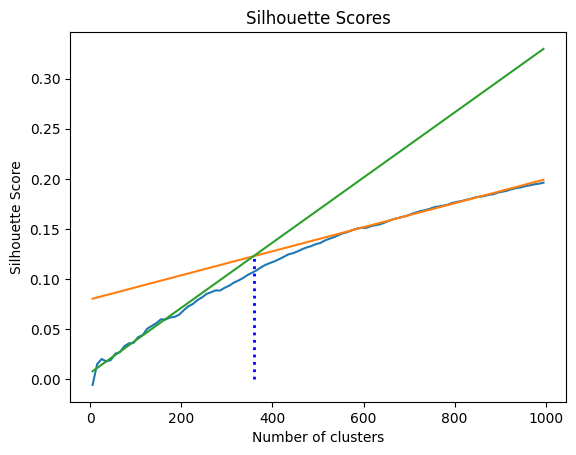

In [9]:
x_full = range(5, 1000, 10)

x_top = range(500, 1000, 10)
y_top = silhouette[50:]
a_top, b_top = np.polyfit(x_top, y_top, 1)

x_bottom = range(5, 200, 10)
y_bottom = silhouette[:20]
a_bottom, b_bottom = np.polyfit(x_bottom, y_bottom, 1)


plt.plot(x_full, silhouette)
plt.plot(x_full, a_top*x_full+b_top)
plt.plot(x_full, a_bottom*x_full+b_bottom)
plt.vlines(x=355, ymin=0, ymax=0.125, colors='blue', ls=':', lw=2, label='stop')


plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

<div class="yellow">
We can see that there are no clear jumps in the silhouette score, but a continuous trend from a higher slope to a smaller one. Here, I define two regions in the graph that I assume to be linear and find an approximate point for the transition from low to high silhouette score values.

The analysis suggests a cluster number of approx. 355.
</div>

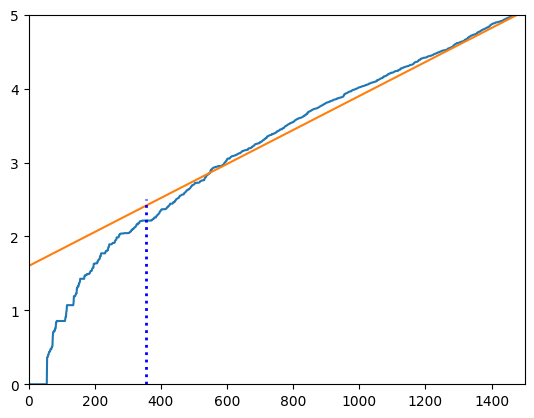

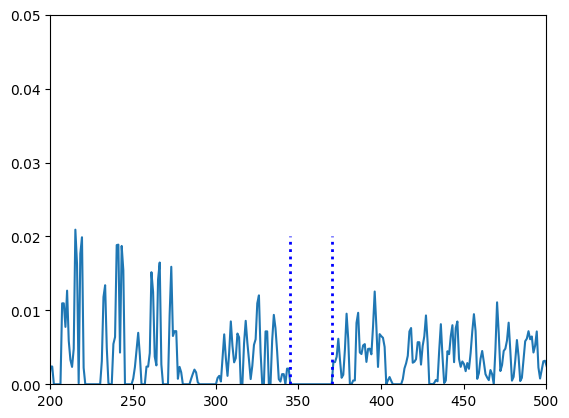

In [10]:
# Calculating the average distance between clusters as function of number of clusters

clusters = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clusters.fit(X_pca)

plt.ylim(0, 5)
plt.xlim(0, 1500)

x_full = np.linspace(0, len(clusters.distances_), len(clusters.distances_))
y_full = clusters.distances_
x_top = x_full[1000:2000]
y_top = clusters.distances_[1000:2000]
a_top, b_top = np.polyfit(x_top, y_top, 1)


# plot the cluster distance

plt.plot(x_full, y_full)
plt.plot(x_full, 1.6+x_full* 0.0023)
plt.vlines(x=355, ymin=0, ymax=2.5, colors='blue', ls=':', lw=2, label='stop')

plt.show()

# plot the first derivative of the cluster distance

plt.ylim(0, 0.05)
plt.xlim(200, 500)
plt.plot(x_full, np.gradient(y_full, x_full))

plt.vlines(x=345, ymin=0, ymax=0.02, colors='blue', ls=':', lw=2, label='stop')
plt.vlines(x=370, ymin=0, ymax=0.02, colors='blue', ls=':', lw=2, label='stop')

plt.show()



<div class="yellow">
We can see that there is a cluster number range (345 to 370) where the cluster distances do not change. This we can go with the previously determined custer number of 355.
</div>

In [11]:
clusters = AgglomerativeClustering(n_clusters=355, linkage='ward')
clusters.fit(X_pca)

AgglomerativeClustering(n_clusters=355)

In [12]:
df_clusters = pd.DataFrame(unique_descriptions, clusters.labels_, columns=['Description'])
df_clusters.index.name = 'product_class'
df_clusters = df_clusters.reset_index()


<div class="yellow">
Finally one has to ultimately evaluate the choice of the cluster number by looking at the results.
</div>

In [13]:
df_clusters[df_clusters['product_class']==319] 

,product_class,Description
108,319,DOORMAT FANCY FONT HOME SWEET HOME
722,319,DOORMAT SPOTTY HOME SWEET HOME
801,319,MAGNETS PACK OF 4 HOME SWEET HOME
909,319,HOME SWEET HOME MUG
1366,319,HOME SWEET HOME METAL SIGN
1670,319,DOORMAT HOME SWEET HOME BLUE
2038,319,PAPERWEIGHT HOME SWEET HOME
3502,319,SET OF 2 TRAYS HOME SWEET HOME
3503,319,HOME SWEET HOME CUSHION COVER
3504,319,STOOL HOME SWEET HOME


<div class="yellow">
In this example (and others too) the clustering has made sense.
</div>

<a id='test_rec'/>

## Recommendations for one customer based on his purchases

[back to TOC](#TOC)

Next, I demonstrate the my solution on one **test**-customer  

In [14]:
df1 = pd.merge(df0, df_clusters, on='Description', how='left')

<div class="yellow">
One-Hot encode customer v.s product matrix 
</div>

In [15]:
df_purchases = pd.crosstab(df0['CustomerID'],df0['Description'])
df_purchases = df_purchases.gt(0).astype(int)

<div class="yellow">
The idea is, that a fraction of the customer's actually purchased products $P$ is set to zero and thus becomes a target for prediction. The logic behind that is that if a customer bought a product $P$, the recommendation algorithm should be able to predict that the customer is interested in $P$. So, If my method recommends products that match the products $P$, it will count as success. 
</div>

In [16]:
# we have to first select a customar, for which we will create recommendations
row = df_purchases.loc['18287'].copy()

# count the number of columns with value 1
num_ones = row.sum()

# calculate the number of columns to set to 0
num_col_to_set_0 = int(round(0.3 * num_ones,0))

# randomly select columns which have value 1 to set to 0
cols_to_set_0 = row[row == 1].sample(n=num_col_to_set_0, random_state=77) 

# update the row with zeros
row.update(cols_to_set_0.map(lambda x: 0))

# put the modified customer row back into the DataFrame
df_purchases.loc['test'] = row




<div class="yellow">
The resulting customer v.s product matrix looks like this:
</div>

In [17]:
df_purchases.tail()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
18281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18283,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
18287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class="yellow">
Here we see that approx. 30% of the test-customer's purchases are set to 0.
</div>

In [18]:
print(df_purchases.loc['18287'].sum())
print(df_purchases.loc['test'].sum())

59
41


<div class="yellow">
We have to remove the "original version" of the test-customer
</div>

In [19]:
df_purchases = df_purchases.drop('18287', axis=0)

<div class="yellow">
Calculate the cosine similarity between all customers
</div>

In [20]:
cosine_sim_table = pd.DataFrame(cosine_similarity(df_purchases), index=df_purchases.index, columns=df_purchases.index)

In [21]:
cosine_sim_table

CustomerID,12346,12347,12348,12349,12350,12352,12353,12354,12355,12356,...,18273,18274,18276,18277,18278,18280,18281,18282,18283,test
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12347,0.0,1.000000,0.064505,0.046449,0.049266,0.039153,0.0,0.012938,0.136641,0.095648,...,0.0,0.029709,0.052668,0.000000,0.032844,0.062318,0.000000,0.113776,0.102705,0.015388
12348,0.0,0.064505,1.000000,0.000000,0.000000,0.000000,0.0,0.028653,0.121046,0.121046,...,0.0,0.065795,0.116642,0.000000,0.000000,0.000000,0.000000,0.000000,0.173937,0.034080
12349,0.0,0.046449,0.000000,1.000000,0.029463,0.109268,0.0,0.030949,0.032686,0.130744,...,0.0,0.106600,0.000000,0.000000,0.039284,0.000000,0.000000,0.068041,0.115615,0.000000
12350,0.0,0.049266,0.000000,0.029463,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061314,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,0.0,0.062318,0.000000,0.000000,0.000000,0.000000,0.0,0.041523,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.105409,1.000000,0.119523,0.000000,0.000000,0.000000
18281,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.049629,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.119523,1.000000,0.000000,0.046349,0.000000
18282,0.0,0.113776,0.000000,0.068041,0.000000,0.038236,0.0,0.000000,0.160128,0.080064,...,0.0,0.174078,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.017700,0.000000


<div class="yellow">
Create a list of top 3 similar customers (nearest neighbours)
</div>

In [22]:
test_cusomer='test'

next_neighbour = list(cosine_sim_table.loc[test_cusomer].sort_values(ascending=False).index[1:4])
print(f"The TOP 3 next neighbors of the test customer are CustomerID=='{next_neighbour}'")
print("Cosine similarities: ", np.round(list(cosine_sim_table.loc[test_cusomer].sort_values(ascending=False)[1:4]),3))

The TOP 3 next neighbors of the test customer are CustomerID=='['15434', '14339', '14813']'
Cosine similarities:  [0.173 0.167 0.159]


<div class="yellow">
Print the TOP 5 product classes from which the nearest neighbor of the test-customer bought items
</div>

In [23]:
row = df_purchases.loc[next_neighbour[0]]
next_neighbour_purchases = pd.DataFrame(list(row[row==1].index), columns=['Description'])
next_neighbour_purchases_classes = pd.merge(next_neighbour_purchases, df_clusters, on='Description', how='left').sort_values(by='product_class')
top_next_neighbour_purchases_classes = next_neighbour_purchases_classes['product_class'].value_counts().head().index
next_neighbour_purchases_classes['product_class'].value_counts().head()

product_class
219    11
60      3
336     2
333     2
30      2
Name: count, dtype: int64

<div class="yellow">
Example: Recommend one item (here: randomly) from each product class. 
</div>

In [116]:
rec_product = []
for l in top_next_neighbour_purchases_classes:
    rec_product.append(df1.query("product_class==@l")[['Description', 'UnitPrice']].drop_duplicates(subset=['Description'], keep='last').sample(1).iloc[0].tolist())
recommendations = pd.DataFrame(rec_product, columns=['Description','UnitPrice'])
total_price = recommendations['UnitPrice'].sum()

# Print recommendations and prices, including the total price
print(recommendations)
print(f"Total price {round(total_price,2)}")

                         Description  UnitPrice
0         HOT WATER BOTTLE KEEP CALM       4.95
1           STRIPY DESIGN SHOWER CAP       0.29
2  PINK HAWAIIAN PICNIC HAMPER FOR 2      12.75
3            KEY CABINET MA CAMPAGNE       9.95
4                  ICE CREAM BUBBLES       0.83
Total price 28.77


<a id='split'/>

## Train/Test Split

[back to TOC](#TOC)



<div class="yellow">
If one wants to test the recommendation engine on the whole dataset (or a significant portion of it), one needs to provide a splitting into train and test datasets.
The best way to split would be one that deals in the best possible way with an unbalanced dataset. After all, the data provided are highly unbalanced, because there are many more items that a custemer did **not** buy then there are items that the custemer **did** buy. 
Thus, the split has to ensure, that both, train and test data contain a relevant amount of actual purchases. This would not be the case if one would make split, for example, at a certain date.
No, further above, I have already presented a way to split the data in such a way that a certain ratio of actually purchased items is realized between the test and train datasets.
    
    
</div>

<div class="yellow">
One-Hot encode customer v.s product matrix: 
</div>

In [25]:
df1 = pd.merge(df0, df_clusters, on='Description', how='left')
df_purchases = pd.crosstab(df1['CustomerID'],df1['Description'])
df_purchases = df_purchases.gt(0).astype(int)


<div class="yellow">
Use rows 3300 to 4336 for testing the recommendation methods.
</div>

In [26]:
split=3300 

In [ ]:
X_test = df_purchases.iloc[split:].copy()
Y_test = df_purchases.iloc[split:].copy()

# here I preper the dataframe in which the recommended (or "predicted") purchases will be stored later
Y_pred=Y_test.copy()
Y_pred[Y_pred>0] = 0

<div class="yellow">
Remove 50% of the 1-values (i.e. of all bought items) from the customer v.s product matrix for each customer individually and store the reduced dataset in `X_test`
</div>

In [28]:
for index, row in X_test.iterrows():
    num_ones = row.sum()
    num_col_to_set_0 = int(round(0.5 * num_ones,0))
    cols_to_set_0 = row[row == 1].sample(n=num_col_to_set_0, random_state=77)
    row.update(cols_to_set_0.map(lambda x: 0))
    


In [29]:
# check how many 1s were removed from the test dataset
np.sum(np.array(X_test) * np.array(df_purchases.iloc[split:].copy()))/np.sum(np.array(df_purchases.iloc[split:].copy()))

0.5002066641231082

In [ ]:
print("Example split:")
print(f"Total number of purchases by CustomerID=='18287': {df_purchases.loc['18287'].sum()}")
print(f"Number of purchases by CustomerID=='18287' in the test set: {X_test.loc['18287'].sum()}")
print(f"Number of purchases by CustomerID=='18287' in the validation set: {Y_test.loc['18287'].sum()}")


Example split:
Total number of purchases by CustomerID=='18287': 59
Number of purchases by CustomerID=='18287' in the test set: 29
Number of purchases by CustomerID=='18287' in the validation set: 30


<div class="yellow">
Recover the 1-values from the customer v.s product matrix that were `sss` removed from `X_test` the previous step. This dataframe contains now the values that we want to predict from putting `X_test` into the recommendation model. 
</div>

In [30]:
Y_test = df_purchases.iloc[split:].copy() - X_test

<div class="yellow">
In the following, I will now test two methods:
    
1. I identify the TOP 5 product-classes (i.e. the product classes from which the most purchases were made) of the "next neighbor" and recommend one product from each category.
2. I identify the single TOP product-class of the "next neighbor" and recommend 5 products from this class.

The methods are also tested against a "dummy" model, whis is: 5 products are drawn from a random product-class.
</div>

<a id='m1'/>

### Method 1: Recommending one product each from several top categories

[back to TOC](#TOC)

In [32]:
method_1 = []
for i in range(5):

    for customer in X_test.index:
        
        # remove the current customer from the dataset 
        X_train=df_purchases.drop(customer, axis=0).copy()
        # reassign the customer with 50% of his transactions removed
        X_train.loc[customer]=X_test.loc[customer]
        # calculate the cosine similarities between all customers 
        cosine_sim_table = pd.DataFrame(cosine_similarity(X_train), index=X_train.index, columns=X_train.index)
        # get the most similar customer
        next_neighbor = list(cosine_sim_table.loc[customer].sort_values(ascending=False).index[1:2])


        # get the descriptions of the next neigbor's purchases
        row = df_purchases.loc[next_neighbor[0]]
        next_neighbor_purchases = pd.DataFrame(list(row[row==1].index), columns=['Description'])
        # get the classes associated with the next neigbor's purchased items
        next_neighbor_purchases_classes = pd.merge(next_neighbor_purchases, df_clusters, on='Description', how='left').sort_values(by='product_class')
        # get the TOP 5 classes from which the most purchases were made by the next neighbor
        top_next_neighbor_purchases_classes = next_neighbor_purchases_classes['product_class'].value_counts().head().index

        # get one random item from each of the TOP classes
        top_next_neighbor_purchases = []
        for cl in top_next_neighbor_purchases_classes:
            top_next_neighbor_purchases.append( list(df1.query("product_class==@cl")[['Description', 'UnitPrice']]
                                                     .drop_duplicates(subset=['Description'], keep='last')
                                                     .sample(1)['Description'])[0] )


        # set the predicted item's values in Y_pred to 1. 
        Y_pred.loc[customer, top_next_neighbor_purchases ]=1
    
    # calculate how many of the predicted items match actually bough items in the test dataset. Output as fraction. 
    method_1.append(np.sum( np.array(Y_pred)*np.array(Y_test) ) / np.sum( np.array(Y_pred)))
    

In [48]:
print(method_1)
print("mean:", round(np.mean(method_1),3), "+-", round(np.std(method_1), 5))

[0.04927057528213598, 0.0516519982686481, 0.051824378508420206, 0.051229829233902555, 0.05011049005589497]
mean: 0.051 +- 0.00098


<a id='m2'/>

### Method 2: Recommending several products from the top 1 category

[back to TOC](#TOC)

In [34]:
method_2 = []
for i in range(5):

    for customer in X_test.index:
        X_train=df_purchases.drop(customer, axis=0).copy()
        X_train.loc[customer]=X_test.loc[customer]
        cosine_sim_table = pd.DataFrame(cosine_similarity(X_train), index=X_train.index, columns=X_train.index)
        next_neighbor = list(cosine_sim_table.loc[customer].sort_values(ascending=False).index[1:2])



        row = df_purchases.loc[next_neighbor[0]]
        next_neighbor_purchases = pd.DataFrame(list(row[row==1].index), columns=['Description'])
        next_neighbor_purchases_classes = pd.merge(next_neighbor_purchases, df_clusters, on='Description', how='left').sort_values(by='product_class')
        
        # get the class from which the most purchases were made by the next neighbor
        top_next_neighbor_purchases_classes = next_neighbor_purchases_classes['product_class'].value_counts().head(1).index


        top_next_neighbor_purchases = []

        # get five random items from that class
        for cl in top_next_neighbor_purchases_classes:
            top_next_neighbor_purchases = list(df1.query("product_class==@cl")[['Description', 'UnitPrice']]
                                               .drop_duplicates(subset=['Description'], keep='last')
                                               .sample(5, replace=True)['Description']
                                               .drop_duplicates() ) 


        Y_pred.loc[customer, top_next_neighbor_purchases ]=1

    method_2.append(np.sum( np.array(Y_pred)*np.array(Y_test) ) / np.sum( np.array(Y_pred)))

In [47]:
print(method_2)
print("mean:", round(np.mean(method_2),3), "+-", round(np.std(method_2), 5))

[0.051684658161596335, 0.0526908023483366, 0.052856041014473026, 0.05274952594380279, 0.052655582735602634]
mean: 0.053 +- 0.00043


<a id='m3'/>

### Method 3: recommending products **randomly**

[back to TOC](#TOC)

In [36]:
method_3 = []
for i in range(5):

    for customer in X_test.index:
        X_train=df_purchases.drop(customer, axis=0).copy()
        X_train.loc[customer]=X_test.loc[customer]


        
        top_next_neighbor_purchases_classes = [np.random.randint(1,355)] 


        top_next_neighbor_purchases = []

        for cl in top_next_neighbor_purchases_classes:
            top_next_neighbor_purchases = list(df1.query("product_class==@cl")[['Description', 'UnitPrice']]
                                               .drop_duplicates(subset=['Description'], keep='last')
                                               .sample(5, replace=True)['Description']
                                               .drop_duplicates() ) 

        
        Y_pred.loc[customer, top_next_neighbor_purchases ]=1

    method_3.append(np.sum( np.array(Y_pred)*np.array(Y_test) ) / np.sum( np.array(Y_pred)))

In [52]:
print(method_3)
print("mean:", round(np.mean(method_3),3), "+-", round(np.std(method_3), 5))

[0.04619536270993857, 0.041607020601232336, 0.03769149936397323, 0.034654203748819175, 0.032159507536323725]
mean: 0.038 +- 0.00499


<a id='#conclusion'/>

## Conclusion

[back to TOC](#TOC)

In [55]:
print(f"Method 2 hits {round(np.mean(method_2)/np.mean(method_3),2)} times more often than a random recommendation" )

Method 2 hits 1.37 times more often than a random recommendation


<div class="yellow">
Method 2 has a 37% higher chance of recommending bundles which contain products that the customer is potentially interested in, compared to fully random recommendations. 
A 37% higher chance of recommending interesting products is a significant improvement over random recommendations and can have a very positive business impact!
Customers are more likely to buy products within bundles that they would not have considered otherwise if the bundles contain at least a few exciting products.
This translates to larger basket sizes, and reduced cart abandonment. 
Customers will also be more satisfied and have a better shopping experience, resulting also in increased time spent on the website. 
Satisfied customers are also more likely to recommend the website to others, which effectively lowers marketing and acquisition costs.

We can ultimately anticipate increased revenue from this.

However, quantifiable metrics are the key to convincing stakeholders. 
To measure the financial impact and strategic value of the recommendation engine, I recommend to perform AB tests. 
Only with data gained by testing the models on "real subjects" a good cost-benefit analysis, comparing development costs to financial gains, can be presented to the stakeholders.

</div>